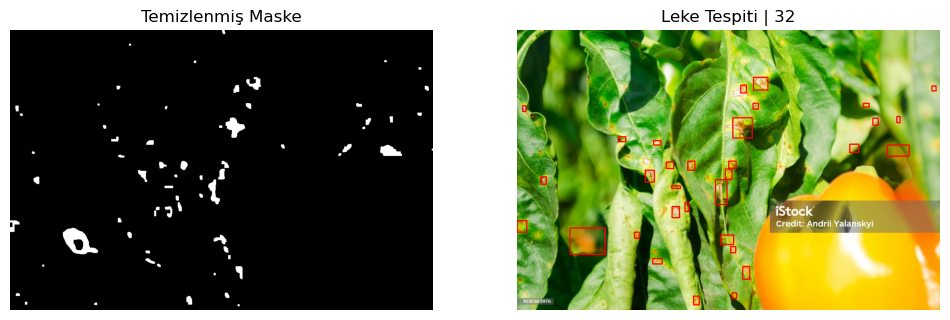

Toplam Leke: 32


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Fotoğraf yüklediğim alan
img = cv2.imread("leaf1.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

h, w = hsv.shape[:2]

# =========== 1) Sarı Biberi Maskeden Çıkarma ===========
# Fotoğrafın sağ alt kısmını tamamen maskeden atıyoruz.
remove_biber = np.zeros((h, w), np.uint8)
cv2.rectangle(remove_biber, (int(w*0.55), int(h*0.45)), (w, h), 255, -1)

# =========== 2) Daha Hassas Kahverengi/Sarı Leke Aralığı ===========
lower = np.array([12, 60, 50])
upper = np.array([30, 255, 220])

mask_color = cv2.inRange(hsv, lower, upper)

# Yalnızca biber olmayan alanlarda maske uyguladım
mask_color = cv2.bitwise_and(mask_color, mask_color, mask=~remove_biber)

# =========== 3) Maske Temizliği ===========
kernel = np.ones((5,5), np.uint8)
mask_clean = cv2.morphologyEx(mask_color, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel, iterations=1)

# =========== 4) Kontur Tespiti ===========
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_detect = img_rgb.copy()
spots = []

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 80 or area > 5000:   # çok küçük ve çok büyük gürültüleri eledim
        continue
    x, y, w_, h_ = cv2.boundingRect(cnt)
    spots.append((x,y,w_,h_))
    cv2.rectangle(img_detect, (x,y), (x+w_,y+h_), (255,0,0), 2)

# =========== 5) Sonucu Göster ===========
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Temizlenmiş Maske")
plt.imshow(mask_clean, cmap='gray')
plt.axis("off")

plt.subplot(1,2,2)
plt.title(f"Leke Tespiti | {len(spots)}")
plt.imshow(img_detect)
plt.axis("off")

plt.show()

print("Toplam Leke:", len(spots))


In [2]:
# --- LEKE ŞİDDETİ ANALİZİ ---

# Şiddet kategorileri için sayıcılar
hafif = 0
orta = 0
ciddi = 0

for (x, y, w, h) in spots:
    alan = w * h   # leke alanı

    if alan < 200:
        hafif += 1
    elif alan < 800:
        orta += 1
    else:
        ciddi += 1

print("Hafif leke sayısı:", hafif)
print("Orta leke sayısı:", orta)
print("Ciddi leke sayısı:", ciddi)


Hafif leke sayısı: 10
Orta leke sayısı: 17
Ciddi leke sayısı: 5


In [3]:
# --- BİTKİ SAĞLIK SKORU HESAPLAMA ---

hafif = 10
orta = 17
ciddi = 5

# Her lekenin ağırlığı
puan = hafif*1 + orta*3 + ciddi*6

# Normalizasyon (maksimum 200 puan üzerinden ölçekledim)
saglik_skoru = 100 - (puan / 200 * 100)

# 0-100 arası sınırladım
saglik_skoru = max(0, min(100, saglik_skoru))

print("Toplam Hasar Puanı:", puan)
print("Bitki Sağlık Skoru:", round(saglik_skoru, 2))


Toplam Hasar Puanı: 91
Bitki Sağlık Skoru: 54.5


In [4]:
import pandas as pd

# Rapor verilerini tek yerde topladım
data = {
    "Özellik": [
        "Toplam Leke Sayısı",
        "Hafif Leke",
        "Orta Leke",
        "Ciddi Leke",
        "Toplam Hasar Puanı",
        "Bitki Sağlık Skoru"
    ],
    "Değer": [
        hafif + orta + ciddi,
        hafif,
        orta,
        ciddi,
        puan,
        f"%{round(saglik_skoru, 2)}"
    ]
}

rapor_df = pd.DataFrame(data)

rapor_df


,Özellik,Değer
0,Toplam Leke Sayısı,32
1,Hafif Leke,10
2,Orta Leke,17
3,Ciddi Leke,5
4,Toplam Hasar Puanı,91
5,Bitki Sağlık Skoru,%54.5


In [5]:
# Bitki durumu yorumu oluşturdum
if saglik_skoru > 80:
    durum = "Bitki sağlıklı görünüyor."
elif saglik_skoru > 60:
    durum = "Hafif hastalık belirtileri mevcut."
elif saglik_skoru > 40:
    durum = "Orta seviyede hastalık mevcut, bakım önerilir."
else:
    durum = "Ciddi hastalık var, acil müdahale gerekebilir."

print("\nGenel Durum:", durum)



Genel Durum: Orta seviyede hastalık mevcut, bakım önerilir.


In [6]:
import numpy as np

# Yaprak görüntüsünün HSV hali zaten vardı, yoksa diye yediden oluşturdum
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Kahverengi (fungal leke) aralığı
kahverengi_maske = cv2.inRange(img_hsv, (5, 50, 20), (20, 255, 200))
kahverengi_oran = np.sum(kahverengi_maske > 0) / (img.shape[0] * img.shape[1]) * 100

# Sararma (besin eksikliği / güneş yanığı)
sari_maske = cv2.inRange(img_hsv, (20, 50, 80), (35, 255, 255))
sari_oran = np.sum(sari_maske > 0) / (img.shape[0] * img.shape[1]) * 100

# Hastalık Tahminleri 
if ciddi > 5 or kahverengi_oran > 10:
    hastalik = "Fungal Yaprak Lekesi (Leaf Spot)"
elif orta > 10 or kahverengi_oran > 5:
    hastalik = "Başlangıç Seviye Fungal Enfeksiyon"
elif sari_oran > 15:
    hastalik = "Azot Eksikliği veya Güneş Yanığı"
elif hafif > 10:
    hastalik = "Hafif Yaprak Lekesi"
else:
    hastalik = "Belirgin bir hastalık belirtisi yok."

print("🌿 Tahmini Hastalık Tipi:", hastalik)


🌿 Tahmini Hastalık Tipi: Başlangıç Seviye Fungal Enfeksiyon


C:\Users\tihay\AppData\Local\Temp\ipykernel_1700\1576116716.py:88: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tihay\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


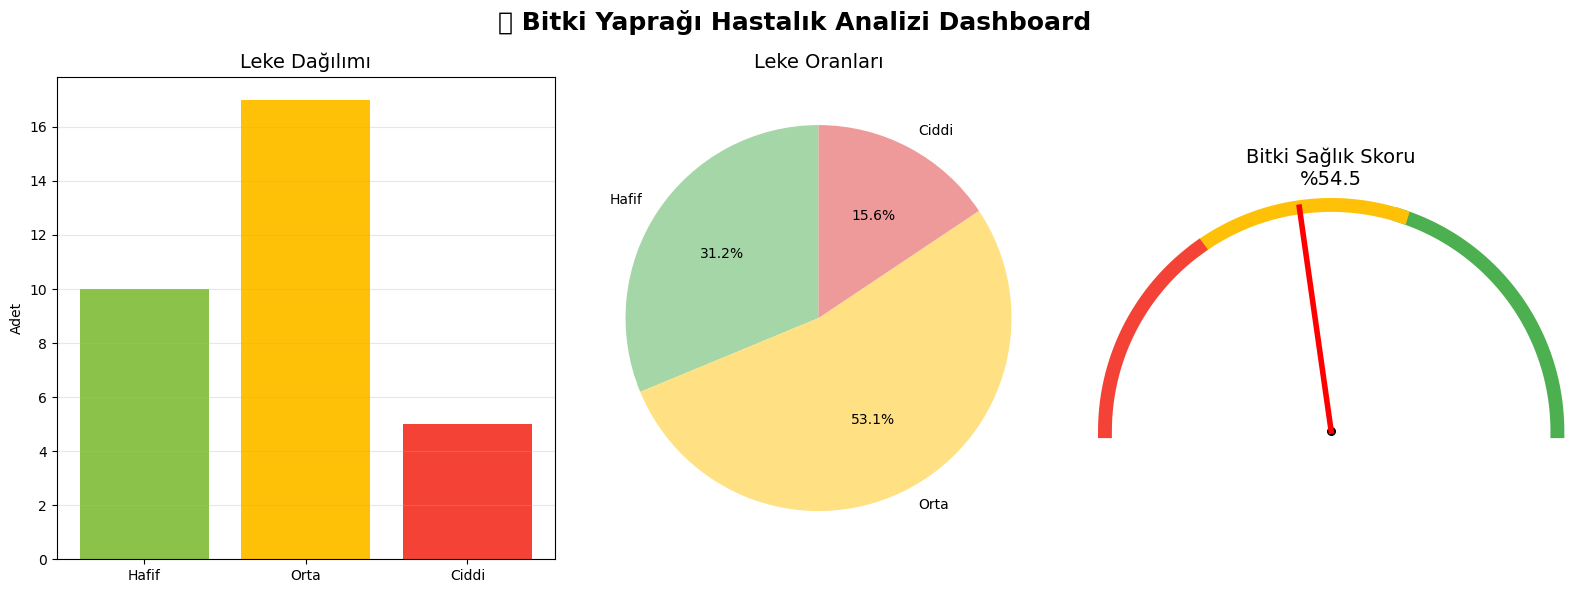

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# DEĞİŞKENLER ( benim girdiğim veriler)
# -----------------------
hafif = hafif
orta = orta
ciddi = ciddi
saglik_skoru = saglik_skoru  # %' lik değer

# -----------------------
# DASHBOARD
# -----------------------
fig = plt.figure(figsize=(16, 6))
fig.suptitle("🌿 Bitki Yaprağı Hastalık Analizi Dashboard", fontsize=18, fontweight="bold")

# -----------------------
# 1) Çubuk Grafik
# -----------------------
ax1 = fig.add_subplot(1, 3, 1)
ax1.bar(["Hafif", "Orta", "Ciddi"], [hafif, orta, ciddi],
        color=["#8BC34A", "#FFC107", "#F44336"])
ax1.set_title("Leke Dağılımı", fontsize=14)
ax1.set_ylabel("Adet")
ax1.grid(axis="y", alpha=0.3)

# -----------------------
# 2) Pasta Grafik
# -----------------------
ax2 = fig.add_subplot(1, 3, 2)
toplam = hafif + orta + ciddi
oranlar = [hafif/toplam*100, orta/toplam*100, ciddi/toplam*100]

ax2.pie(oranlar, labels=["Hafif", "Orta", "Ciddi"],
        autopct="%1.1f%%",
        colors=["#A5D6A7", "#FFE082", "#EF9A9A"],
        startangle=90)
ax2.set_title("Leke Oranları", fontsize=14)

# -----------------------
# 3) RENKLİ GÖSTERGE (GAUGE)
# -----------------------
ax3 = fig.add_subplot(1, 3, 3)

# Yarım daire çizimi için açı
angles = np.linspace(0, np.pi, 300)
x = np.cos(angles)
y = np.sin(angles)

# Renkli bölümler için aralıklar:
# Sağlıklı (%0–40) -> Yeşil
# Orta Risk (%40–70) -> Sarı
# Yüksek Risk (%70–100) -> Kırmızı

# Renkli yaylar
ax3.plot(np.cos(np.linspace(0, np.pi*0.4, 100)),
         np.sin(np.linspace(0, np.pi*0.4, 100)),
         color="#4CAF50", linewidth=10)

ax3.plot(np.cos(np.linspace(np.pi*0.4, np.pi*0.7, 100)),
         np.sin(np.linspace(np.pi*0.4, np.pi*0.7, 100)),
         color="#FFC107", linewidth=10)

ax3.plot(np.cos(np.linspace(np.pi*0.7, np.pi, 100)),
         np.sin(np.linspace(np.pi*0.7, np.pi, 100)),
         color="#F44336", linewidth=10)

# -----------------------
# İğne çizimi
# -----------------------
# Skoru açıya dönüştür (0–100 → 0–180 derece)
angle_deg = (saglik_skoru / 100) * 180
angle_rad = np.deg2rad(angle_deg)

needle_x = np.cos(angle_rad)
needle_y = np.sin(angle_rad)

ax3.plot([0, needle_x], [0, needle_y], color="red", linewidth=4)
ax3.scatter(0, 0, color="black", s=30)  # merkez noktası

# Başlık
ax3.set_title(f"Bitki Sağlık Skoru\n%{saglik_skoru:.1f}", fontsize=14)

ax3.set_aspect("equal")
ax3.axis("off")

plt.tight_layout()
plt.show()
